In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
import theano
from theano import tensor as tt
import pingouin as pg
from scipy.stats import norm
from systole.detection import oxi_peaks, rr_artefacts
from plotting import raincloud

sns.set_context('talk')

# Post hos estimation of psychometric functions - PyMC3

In [16]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
merged_df = pd.read_csv(path + '/data/merged.txt')
merged_df = merged_df[~merged_df.Alpha.isnull()]
merged_df = merged_df[~merged_df.Estimation.isnull()]

In [17]:
def comulative_normal(x, alpha, beta, s=np.sqrt(2)):
    # Cumulative distribution function for the standard normal distribution
    return 0.5 * (1 + tt.erf((x-alpha)/(beta*s)))

def logistic(x, alpha, beta):
    return 1 / (1 + tt.exp(-beta*(x-alpha)))

def singleSubject(this_df):

  # ---------------
  # Preprocess data
  # ---------------
  x, n, r = np.zeros(163), np.zeros(163), np.zeros(163)

  for ii, intensity in enumerate(np.arange(-40.5, 41, 0.5)):
      x[ii] = intensity
      n[ii] = sum(this_df.Alpha == intensity)
      r[ii] = sum((this_df.Alpha == intensity) & (this_df.Estimation == 'More'))
  rprop = r/n

  nstim2 = np.shape(x)
  xmean = np.nanmean(x)
  xmeanvect = np.repeat(xmean, nstim2)

  # remove nans
  validmask = np.isnan(x.flatten())==False
  xij2, nij2, rij2 = x.flatten(), n.flatten(), r.flatten()
  xij, nij, rij = xij2[validmask], nij2[validmask], rij2[validmask]
  xvect = xmeanvect[validmask]

  # psi estimates
  slope = this_df.EstimatedSlope.iloc[-1]
  threshold = this_df.EstimatedThreshold.iloc[-1]

  # ------------------------------
  # Cumulative normal distribution
  # ------------------------------
  with pm.Model() as model1:

    alpha = pm.Uniform('alpha', lower=-40.5, upper=40.5)
    beta = pm.Uniform("beta", lower=0, upper=40)
    
    thetaij = pm.Deterministic('thetaij', comulative_normal(xij-xvect, alpha, beta))
    
    rij_ = pm.Binomial('rij', p=thetaij, n=nij, observed=rij)
    trace1 = pm.sample(chains=4, cores=4, tune=2000)

  stats = pm.summary(trace1, ['alpha', 'beta'])
  bayesThresholdCN = stats['mean']['alpha']
  bayesSlopeCN = stats['mean']['beta']

  #pm.traceplot(trace1, var_names=['alpha', 'beta'])

  # ---------------------
  # Logistic distribution
  # ---------------------
  #with pm.Model() as model2:

     # alpha = pm.Normal('alpha', mu=0, tau=0.01)
    #  beta = pm.HalfNormal("beta", tau=0.01)

   #   thetaij = pm.Deterministic("thetaij", logistic(xij, alpha, beta))

  #    trace2 = pm.sample(chains=4, cores=4, tune=2000)
  
  #stats = pm.summary(trace2, ['alpha', 'beta'])
  #bayesThresholdLG = stats['mean']['alpha']
  #bayesSlopeLG = stats['mean']['beta']

  #pm.traceplot(trace2, var_names=['alpha', 'beta'])

  bayesThresholdLG, bayesSlopeLG = None, None

  return slope, threshold, bayesThresholdCN, bayesSlopeCN, bayesThresholdLG, bayesSlopeLG

In [ ]:
summary_df = pd.DataFrame([])
for subject in merged_df.Subject.unique():
  for modality in ['Intero', 'Extero']:
    this_df = merged_df[(merged_df.Subject == subject) & (merged_df.Modality == modality)]

    # Drop first up/downtrials if incorrect to avoid contamination
    this_df = this_df[~((this_df.Alpha.abs() == 40.5) & 
                        (this_df.ResponseCorrect == 0) & 
                        (this_df.StairCond != 'psi'))]

    # Drop trials with decision time < 100 ms
    this_df = this_df[~(this_df.EstimationRT < .1)]

    slope, threshold, bayesThresholdCN, bayesSlopeCN, bayesThresholdLG, bayesSlopeLG = singleSubject(this_df)

    summary_df = summary_df.append(pd.DataFrame({'Subject': subject,
                                                'Condition': modality,
                                                'Threshold': [threshold],
                                                'Slope': [slope],
                                                'BayesianThresholdCN': [bayesThresholdCN],
                                                'BayesianSlopeCN': [bayesSlopeCN],
                                                #'BayesianThresholdLG': [bayesThresholdLG],
                                                #'BayesianSlopeLG': [bayesSlopeLG],
                                                 }), ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\theano\gof\opt.py", line 2129, in process_node
    replacements = lopt.transform(node)
  File "C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\opt.py", line 7342, in local_grad_log_erfc_neg
    if not exp_in.owner.inputs[0].owner:
AttributeError: 'NoneType

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERR

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (thean

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (thean

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 110 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 109 seconds.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elem

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 113 seconds.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elem

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 117 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERR

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 112 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (thea

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 123 seconds.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elem

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 118 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERR

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 119 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8859084614952785, but should be close to 0.8. Try to increase the number of tuning steps.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inf

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 112 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7015525296819378, but should be close to 0.8. Try to increase the number of tuning steps.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assi

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 124 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (thea

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 119 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (th

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 116 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 118 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (thea

# Correlation between psi and Bayesian fit

Import summary statistics from Bayesian psychometric fits.

In [3]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
bayesPsycho_df = pd.read_csv(path + '/data/bayesianPsychophysic.txt')

## Threshold

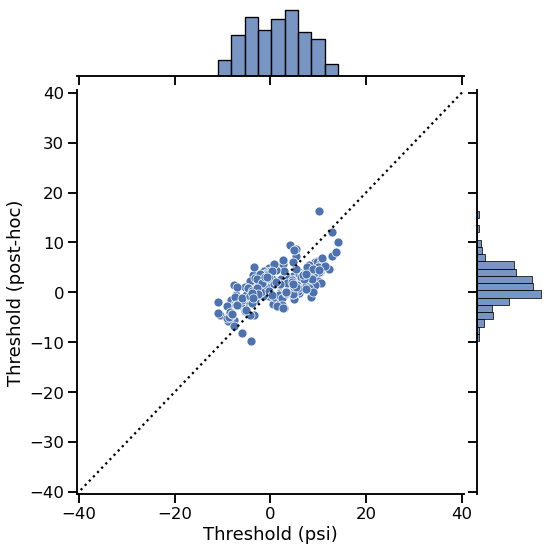

In [4]:
g = sns.jointplot(data=bayesPsycho_df[bayesPsycho_df.Condition=='Extero'],
                  x='Threshold', y='BayesianThresholdCN', xlim=(-40.5, 40.5),
                  ylim=(-40.5, 40.5), color='#4c72b0', height=8)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')
g.ax_joint.set_ylabel('Threshold (post-hoc)')
g.ax_joint.set_xlabel('Threshold (psi)')
plt.savefig(path + '/figures/thresholdExtero.svg', dpi=300)

In [6]:
pg.corr(x=bayesPsycho_df[bayesPsycho_df.Condition=='Extero'].Threshold,
        y=bayesPsycho_df[bayesPsycho_df.Condition=='Extero'].BayesianThresholdCN, method='spearman')

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,213,0.653932,"[0.57, 0.72]",0.427627,0.422176,2.270956e-27,1.0


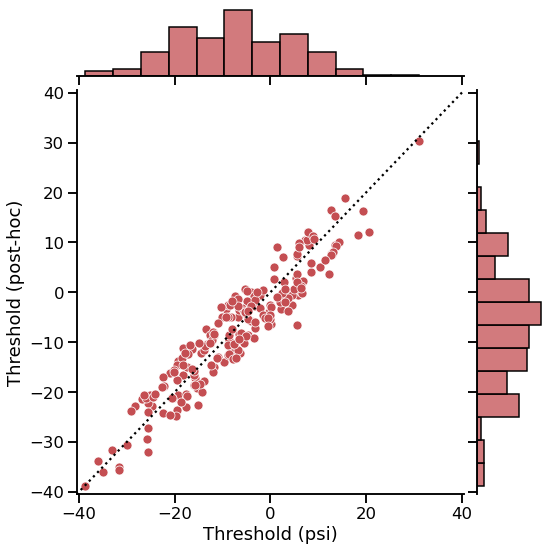

In [7]:
g = sns.jointplot(data=bayesPsycho_df[bayesPsycho_df.Condition=='Intero'], x='Threshold',
                  y='BayesianThresholdCN', xlim=(-40.5, 40.5), ylim=(-40.5, 40.5), color='#c44e52', height=8)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')
g.ax_joint.set_ylabel('Threshold (post-hoc)')
g.ax_joint.set_xlabel('Threshold (psi)')
plt.savefig(path + '/figures/thresholdIntero.svg', dpi=300)

In [8]:
pg.corr(x=bayesPsycho_df[bayesPsycho_df.Condition=='Intero'].Threshold,
        y=bayesPsycho_df[bayesPsycho_df.Condition=='Intero'].BayesianThresholdCN, method='spearman')

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,213,0.934189,"[0.91, 0.95]",0.872709,0.871497,2.111325e-96,1.0


## Slope

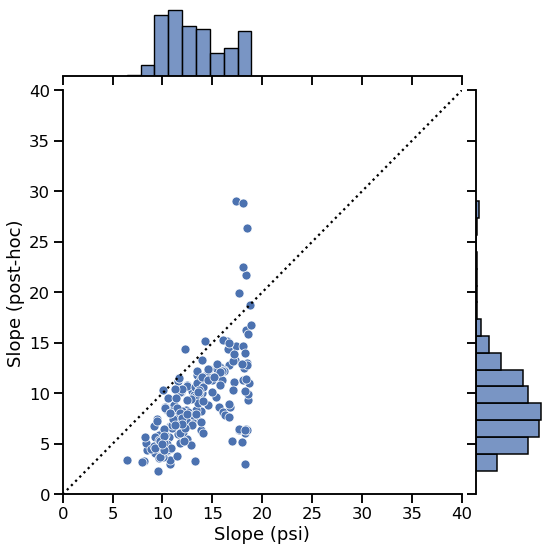

In [12]:
g = sns.jointplot(data=bayesPsycho_df[bayesPsycho_df.Condition=='Extero'], x='Slope',
                  y='BayesianSlopeCN', xlim=(0, 40), ylim=(0, 40), color='#4c72b0', height=8)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')
g.ax_joint.set_ylabel('Slope (post-hoc)')
g.ax_joint.set_xlabel('Slope (psi)')
plt.savefig(path + '/figures/slopeExtero.svg', dpi=300)

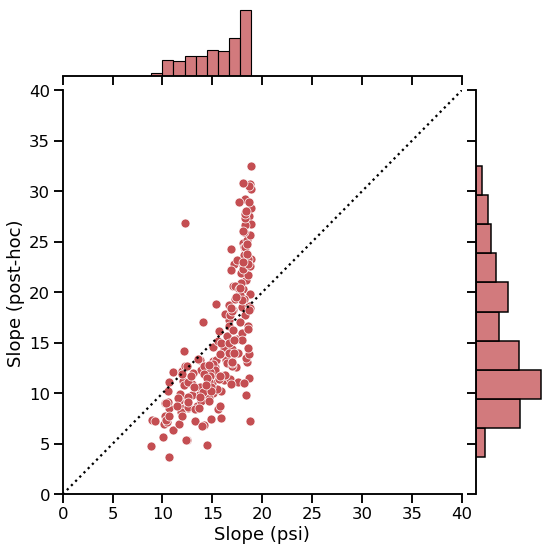

In [13]:
g = sns.jointplot(data=bayesPsycho_df[bayesPsycho_df.Condition=='Intero'], x='Slope',
                  y='BayesianSlopeCN', xlim=(0, 40), ylim=(0, 40), color='#c44e52', height=8)
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')
g.ax_joint.set_ylabel('Slope (post-hoc)')
g.ax_joint.set_xlabel('Slope (psi)')
plt.savefig(path + '/figures/slopeIntero.svg', dpi=300)

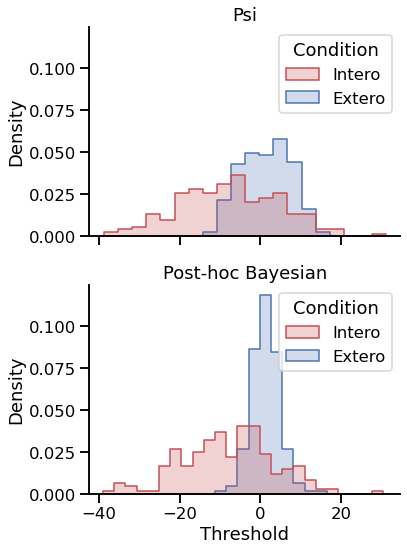

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharey=True, sharex=True)
sns.histplot(data=bayesPsycho_df, x='Threshold', hue='Condition', palette=['#c44e52', '#4c72b0'], ax=axs[0], common_norm=False, element="step", stat="density")
sns.histplot(data=bayesPsycho_df, x='BayesianThresholdCN', hue='Condition', palette=['#c44e52', '#4c72b0'], ax=axs[1], common_norm=False, element="step", stat="density")
axs[1].set_xlabel('Threshold')
axs[0].set_title('Psi')
axs[1].set_title('Post-hoc Bayesian')
plt.tight_layout()
sns.despine()
plt.savefig(path + '/figures/thresholdHist.svg', dpi=300)

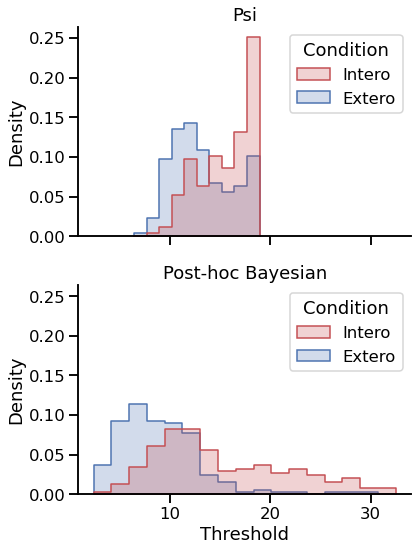

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharey=True, sharex=True)
sns.histplot(data=bayesPsycho_df, x='Slope', hue='Condition', palette=['#c44e52', '#4c72b0'], ax=axs[0], common_norm=False, element="step", stat="density")
sns.histplot(data=bayesPsycho_df, x='BayesianSlopeCN', hue='Condition', palette=['#c44e52', '#4c72b0'], ax=axs[1], common_norm=False, element="step", stat="density")
axs[0].set_title('Psi')
axs[1].set_title('Post-hoc Bayesian')
axs[1].set_xlabel('Threshold')
plt.tight_layout()
sns.despine()
plt.savefig(path + '/figures/slopeHist.svg', dpi=300)

# Psychophysic parameters of the task

## Psychometric functions parameters

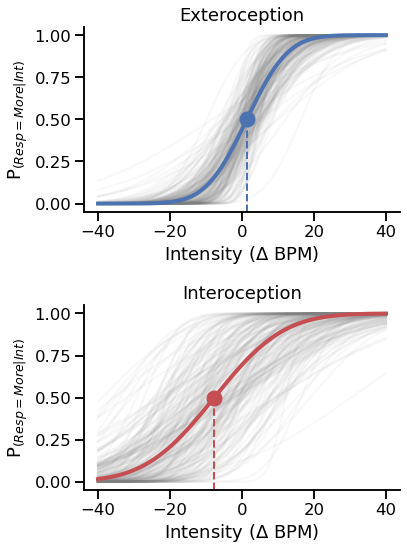

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
for i, condition, col in zip((0, 1), ['Extero', 'Intero'], ['#4c72b0', '#c44e52']):
    threshold, slope = [], []
    for subject in bayesPsycho_df.Subject.unique():
        threshold.append(bayesPsycho_df.BayesianThresholdCN[(bayesPsycho_df.Condition == condition) & (bayesPsycho_df.Subject == subject)].values)
        slope.append(bayesPsycho_df.BayesianSlopeCN[(bayesPsycho_df.Condition == condition) & (bayesPsycho_df.Subject == subject)].values)

        # Plot Psi estimate of psychometric function
        axs[i].plot(np.linspace(-40, 40, 500), 
                (norm.cdf(np.linspace(-40, 40, 500), loc=threshold[-1], scale=slope[-1])),
                '-', color='gray', alpha=.05)
        axs[i].set_ylabel('P$_{(Resp = More|Int)}$')
        axs[i].set_xlabel('Intensity ($\Delta$ BPM)')
        axs[i].set_title(f'{condition}ception')
    axs[i].plot(np.linspace(-40, 40, 500), 
            (norm.cdf(np.linspace(-40, 40, 500), loc=np.array([threshold]).mean(), scale=np.array([slope]).mean())),
            '-', color=col, linewidth=4)
    axs[i].plot(np.array([threshold]).mean(), 0.5, 'o', color=col, markersize=15)
    axs[i].axvline(x=np.array([threshold]).mean(), ymin=0, ymax=0.5, linestyle='--', color=col, linewidth=2)
plt.tight_layout()
sns.despine()
plt.savefig(path + '/figures/Supplement1.svg', dpi=600)

## Threshold and slope parameters

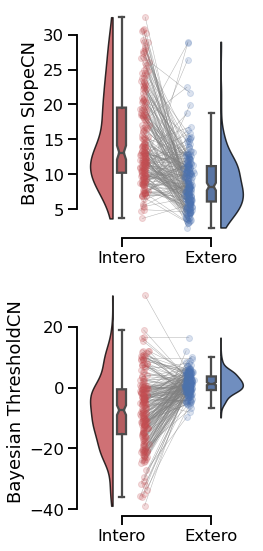

In [18]:
sns.set_context('talk')
fig, axs = plt.subplots(2, 1, figsize=(4, 8))
axs = axs.ravel()
for i, metric in enumerate(['BayesianSlopeCN', 'BayesianThresholdCN']):
    raincloud(data=bayesPsycho_df, x='Condition', y=metric, ax=axs[i], palette=['#c44e52', '#4c72b0'])
    axs[i].set_ylabel(metric[:8] + ' ' + metric[8:])
    axs[i].set_xlabel('')
plt.tight_layout()
sns.despine(trim=10)
plt.savefig(path + '/figures/Supplement2.svg', dpi=600)

In [20]:
pg.pairwise_ttests(data=bayesPsycho_df, dv='BayesianThresholdCN', within='Condition', effsize='cohen')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Condition,Intero,Extero,True,True,-11.429822,212.0,two-sided,6.967258e-24,5.604e+20,-1.056476


In [21]:
pg.pairwise_ttests(data=bayesPsycho_df, dv='BayesianSlopeCN', within='Condition', effsize='cohen')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Condition,Intero,Extero,True,True,11.547515,212.0,two-sided,3.009412e-24,1.28e+21,1.114868
